# Week 10 Relative Representations

In this notebook we attempt to reproduce some results from the paper "RELATIVE REPRESENTATIONS ENABLE ZERO-SHOT LATENT SPACE COMMUNICATION" found at 'https://arxiv.org/abs/2209.15430'.
The paper shows how representing ones data using a distance measure to a selection of points leads to an ability to use models trained on one dataset on another. Here we will show how GloVe and Fasttext vectors embedded according to the method are much more similar than the original embeddings.


### Exercise 1

**1. In you own words, what are relative representations and how do we construct them?**


**2. Explain why you would expect this method to allow for communication between latent spaces.**
- How should we choose the anchors in each space?

**3. How would you measure whether two latent spaces have similar representations?**



In [1]:
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
from tqdm.notebook import tqdm

from collections import defaultdict
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier

### Exercise 2 Loading the data
**1. $\star$ For those interested in doing the whole thing from scratch, download the following:**


For fasttext we want the `1. wiki-news-300d-1M.vec.zip: 1 million word vectors trained on Wikipedia 2017, UMBC webbase corpus and statmt.org news dataset (16B tokens).` found at

`https://fasttext.cc/docs/en/english-vectors.html`

For GloVe we want the `Wikipedia 2014 + Gigaword 5 (6B tokens, 400K vocab, uncased, 50d, 100d, 200d, & 300d vectors, 822 MB download): glove.6B.zip` found at 

`https://nlp.stanford.edu/projects/glove/`

In [ ]:
def load_vectors_from_file(filename, n_words, encoding='utf-8', specified_word_set=None):
    p_bar = tqdm(total=n_words, desc='Loading word vectors', position=0, leave=True)
    embeddings_dict = {}
    with open(filename, 'r', encoding=encoding) as f:
        for line in f:
            values = line.split()
            word = values[0]
            if specified_word_set is None or word in specified_word_set:
                vector = np.asarray(values[1:], "float32")
                if len(vector) > 1:
                    embeddings_dict[word] = vector
                    p_bar.update(1)
                    if len(embeddings_dict) == n_words:
                        break
        else:
            print("Reached end of file!")
    print(f'Loaded {len(embeddings_dict)} word vectors')
    embeddings_dict = dict(sorted(embeddings_dict.items()))
    
    all_vectors = np.array(list(embeddings_dict.values()))
    normalisation = all_vectors.mean(axis=0)
    all_vectors -= normalisation
    embeddings_dict = {word: vector for word, vector in zip(embeddings_dict.keys(), all_vectors)}
    
    return embeddings_dict

In [ ]:
n_words = 40_000
filename_glove = "glove.6B.300d.txt"
embeddings_dict_glove = load_vectors_from_file(filename_glove, n_words=n_words)

In [ ]:
filename_fasttext = 'wiki-news-300d-1M.vec'
embeddings_dict_fasttext = load_vectors_from_file(filename_fasttext, n_words=n_words, specified_word_set=None)

**2. Create a function which takes two dictionaries and removes all keys that do not occur in both**


In [ ]:
def ensure_intersecting_keys(dict1, dict2):
    """
    Modifies the input dictionaries to only keep keys that exist in both dictionaries.
    returns nothing
    
    Parameters:
    dict1 (dict): The first dictionary to be modified.
    dict2 (dict): The second dictionary to be modified.
    """
    # Find the intersection of the keys
    common_keys = set(dict1.keys()).intersection(set(dict2.keys()))
    
    # Remove keys from dict1 that are not in the intersection
    keys_to_remove = set(dict1.keys()) - common_keys
    for key in keys_to_remove:
        del dict1[key]
    print(f'Removed {len(keys_to_remove)}, leaving {len(dict1.keys())}')

    # Remove keys from dict2 that are not in the intersection
    keys_to_remove = set(dict2.keys()) - common_keys
    for key in keys_to_remove:
        del dict2[key]

*If you chose not to download the original data here are two dictionaries to test on:*

In [ ]:
dict1 = {
    'dragon': 'fire',
    'unicorn': 'magic',
    'phoenix': 'rebirth'
}

dict2 = {
    'unicorn': 'rainbow',
    'phoenix': 'ashes',
    'mermaid': 'ocean'
}
ensure_intersecting_keys(dict1, dict2)
print(dict1)
print(dict2)

*Only run this if you have downloaded the data*

In [88]:
ensure_intersecting_keys(embeddings_dict_glove, embeddings_dict_fasttext)

Removed 17994, leaving 22006


**3. $\star$ If you downloaded and ensured non-intersecting dictionaries, save them here:**

In [2]:
filename_glove_pickle = "Glove_ex_10.pkl"
filename_fasttext_pickle = "FastText_ex_10.pkl"

In [ ]:
with open(filename_glove_pickle, "wb") as f:
    pickle.dump(embeddings_dict_glove, f)

with open(filename_fasttext_pickle, "wb") as f:
    pickle.dump(embeddings_dict_fasttext, f)

**4. Load two dictionaries of vectors that have been processed**

In [3]:
with open(filename_glove_pickle, "rb") as f:
    embeddings_dict_glove = pickle.load(f)

with open(filename_fasttext_pickle, "rb") as f:
    embeddings_dict_fasttext = pickle.load(f)

**5. Look at what the dictionaries contain in order to prepare for the next exercise**

In [ ]:
for el in embeddings_dict_fasttext.items():
    print(el)
    break

In [ ]:
for el in embeddings_dict_glove.items():
    print(el)
    break

## Exercise 3 Creating the relative representations
*In the paper they chose 300 anchors for the relative representations, so we suggest you do so too.*

**1. Create a function that takes an embedding dictionary and creates a dictionary of the same words but using relative representations. Also return the anchor words in order to ensure that the relative representations are of parallel words**


In [8]:
def get_anchors(embeddings_dict, n_anchors=300):
    """Randomly sample n_anchors from embeddings_dict and return as a matrix where each row is a relative representation vector. Returns shape (embedding_dim, n_anchors)"""
    anchor_words = random.sample(list(embeddings_dict.keys()), n_anchors)
    
    return anchor_words

def get_relative_representations(embeddings_dict, similarity_measure, n_anchors=300, anchor_words=None):
    """Using a given similarity measure and embedding dictionary, calculate the relative representations and return as a matrix where each row is a relative representation vector. Returns shape (n_samples, n_anchors)"""
    relative_representations_dict = dict()
    anchor_words = get_anchors(embeddings_dict, n_anchors=n_anchors) if anchor_words is None else anchor_words
    anchor_vectors = np.vstack([embeddings_dict[word] for word in anchor_words])

    for word in tqdm(embeddings_dict.keys(), desc='Calculating relative representations',  position=0, leave=True):
        embedding = embeddings_dict[word]

        relative_representation = similarity_measure(embedding, anchor_vectors)
        relative_representations_dict[word] = relative_representation

    return relative_representations_dict, anchor_words

**2. Create a cosine_similarity function which calculates the cosine similarity between a vector and a matrix**

In [9]:
def cosine_similarity(word_vector, anchors):
    """Calculate the cosine similarity between the word vector and each of the anchors. Returns a vector of shape (n_anchors,)"""
    # Normalize the word vector
    word_vector_norm = np.linalg.norm(word_vector)
    word_vector_normalized = word_vector / word_vector_norm
    # Normalize the anchor rows
    row_norms = np.linalg.norm(anchors, axis=1)
    anchors_normalized = anchors / row_norms[:, np.newaxis]
    # Compute the cosine similarities (dot product of normalized word_vector and each row)
    cosine_similarities = np.dot(anchors_normalized, word_vector_normalized)
    
    return cosine_similarities

In [10]:
n_anchors = 300
random.seed(420)
relrep_dict_glove, anchor_words = get_relative_representations(embeddings_dict_glove, n_anchors=n_anchors, similarity_measure=cosine_similarity)

Calculating relative representations:   0%|          | 0/22006 [00:00<?, ?it/s]

In [ ]:
relrep_dict_fasttext, anchor_words = get_relative_representations(embeddings_dict_fasttext, n_anchors=n_anchors, similarity_measure=cosine_similarity, anchor_words=anchor_words)

**3. Now it's time to visualise cluster in each of the latent spaces. We will do so by sampling n random words, **

In [ ]:
def sample_random_words(words, n):    
    random_sample = random.sample(words, n)
    return random_sample

In [ ]:
def create_2d_clusters(cluster_centers, embeddings, n_neighbors=200):
    """
    Find the n_points nearest neighbors in the embeddings matrix for each cluster center and use PCA to reduce the dimensionality of the points to 2.
    
    Parameters:
    cluster_centers (np.array): An array of cluster center vectors.
    embeddings (np.array): An array of embedding vectors.
    n_neighbors (int): The number of nearest neighbors to find for each cluster center.
    
    Returns:
    pca_results: A numpy array of shape (n_clusters, n_neighbors, 2) containing the two principal components of the nearest neighbors of each of the clusters centers
    """
    pca_results = np.empty(shape=(cluster_centers.shape[0], n_neighbors, 2))
    
    # Fit the NearestNeighbors model
    nn_model = NearestNeighbors(n_neighbors=n_neighbors)
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)
    nn_model.fit(embeddings_2d)
    
    for i, center in enumerate(cluster_centers):
        # Find the n_points nearest neighbors
        center_2d = pca.transform(center.reshape((1, -1)))
        distances, indices = nn_model.kneighbors(center_2d)
        nearest_neighbors = embeddings_2d[indices[0]]
                
        # Store the results in the dictionary
        pca_results[i] = nearest_neighbors
    
    return pca_results

def visualize_clusters(pca_results, name='', y_lim=(None,), x_lim=(None,)):
    for points in pca_results:
        plt.scatter(points[:, 0], points[:, 1], marker='o', s=2.5)
    plt.title(name)
    plt.ylim(*y_lim)
    plt.xlim(*x_lim)
    plt.grid(True)

In [13]:
n_centers = 4

words = list(embeddings_dict_glove.keys())
pca_words = sample_random_words(words, n=n_centers)

centers_rel_rep_glove = np.vstack([relrep_dict_glove[word] for word in pca_words])
centers_rel_rep_fasttext = np.vstack([relrep_dict_fasttext[word] for word in pca_words])
centers_o_rep_glove = np.vstack([embeddings_dict_glove[word] for word in pca_words])
centers_o_rep_fasttext = np.vstack([embeddings_dict_fasttext[word] for word in pca_words])

In [14]:
own_reps_glove = np.vstack(list(embeddings_dict_glove.values()))
own_reps_fasttext = np.vstack(list(embeddings_dict_fasttext.values()))
rel_reps_glove = np.vstack(list(relrep_dict_glove.values()))
rel_reps_fasttext = np.vstack(list(relrep_dict_fasttext.values()))

In [15]:
own_reps_glove.shape, own_reps_fasttext.shape, centers_o_rep_glove.shape, centers_rel_rep_glove.shape

((22006, 300), (22006, 300), (4, 300), (4, 300))

In [16]:
n_points_visualisation = 100
pca_glove_own = create_2d_clusters(centers_o_rep_glove, embeddings=own_reps_glove, n_neighbors=n_points_visualisation)
pca_glove_relative = create_2d_clusters(centers_rel_rep_glove, embeddings=rel_reps_glove, n_neighbors=n_points_visualisation)

In [17]:
pca_fasttext_own = create_2d_clusters(centers_o_rep_fasttext, embeddings=own_reps_fasttext, n_neighbors=n_points_visualisation)
pca_fasttext_relative = create_2d_clusters(centers_rel_rep_fasttext, embeddings=rel_reps_fasttext, n_neighbors=n_points_visualisation)

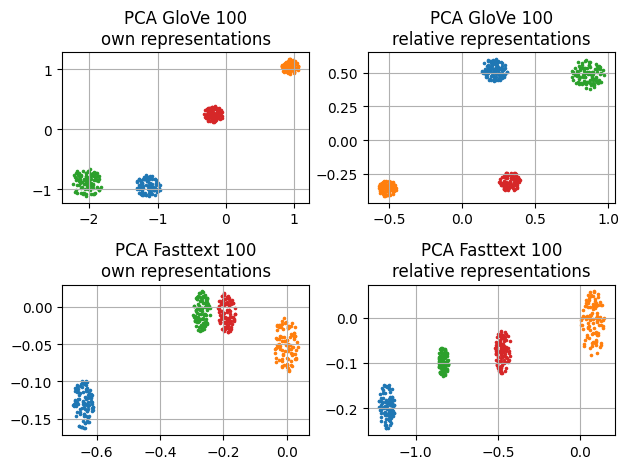

In [18]:
fig, axs = plt.subplots(nrows=2, ncols=2)
plt.sca(axs[0, 0])
visualize_clusters(pca_glove_own, f'PCA GloVe {n_points_visualisation}\nown representations')
plt.sca(axs[1, 0])
visualize_clusters(pca_fasttext_own, f'PCA Fasttext {n_points_visualisation}\nown representations')
plt.sca(axs[0, 1])
visualize_clusters(pca_glove_relative, f'PCA GloVe {n_points_visualisation}\nrelative representations')
plt.sca(axs[1, 1])
visualize_clusters(pca_fasttext_relative, f'PCA Fasttext {n_points_visualisation}\nrelative representations')

plt.tight_layout()

### Exercise 4 Similarity metrics

In [19]:
def mean_reciprocal_rank(query_vector, matrix):
    """
    Calculate the Mean Reciprocal Rank (MRR) given a query vector and a matrix.
    
    Parameters:
    query_vector (np.array): A vector representing the query.
    matrix (np.array): A matrix where each row represents a document.
    
    Returns:
    float: The MRR score.
    """
    # Compute relevance scores as dot products between the query_vector and each row in the matrix
    relevance_scores = np.dot(matrix, query_vector)
    
    # Get the ranks of the documents sorted by relevance (highest relevance first)
    sorted_indices = np.argsort(relevance_scores)[::-1]
    
    # Find the rank of the first relevant document
    first_relevant_rank = np.where(sorted_indices == 0)[0][0] + 1  # Adding 1 to make rank 1-based
    
    # Calculate the reciprocal rank
    reciprocal_rank = 1 / first_relevant_rank
    
    return reciprocal_rank

In [20]:
K = 10
knn_rel_glove = NearestNeighbors(n_neighbors=K)
knn_rel_glove.fit(rel_reps_glove)
nearest_neighbors_rel_glove = knn_rel_glove.kneighbors(rel_reps_glove, return_distance=False)

In [21]:
knn_rel_fasttext = NearestNeighbors(n_neighbors=K)
knn_rel_fasttext.fit(rel_reps_fasttext)
nearest_neighbors_rel_fasttext = knn_rel_fasttext.kneighbors(rel_reps_fasttext, return_distance=False)

In [22]:
knn_own_glove = NearestNeighbors(n_neighbors=K)
knn_own_glove.fit(own_reps_glove)
nearest_neighbors_own_glove = knn_own_glove.kneighbors(own_reps_glove, return_distance=False)

In [23]:
knn_own_fasttext = NearestNeighbors(n_neighbors=K)
knn_own_fasttext.fit(own_reps_fasttext)
nearest_neighbors_own_fasttext = knn_own_fasttext.kneighbors(own_reps_fasttext, return_distance=False)

In [31]:
def compute_knn_results(NNs, reps, names_knn, verbose=True):
    result_rows = []

    for i_knn, knn in tqdm(enumerate(NNs), desc="KNN", total=len(names_knn)):
        for i_repr_1, repr_1 in tqdm(enumerate(reps), desc="Representation 1", total=len(names_knn)):
            for i_repr_2, repr_2 in tqdm(enumerate(reps), desc="Representation 2", total=len(names_knn)):
                temp_cossim, temp_mrr = [], []
                for i_vect, vector in enumerate(repr_1):
                    neighbors = knn[i_vect]
                    vector_subset = repr_2[neighbors]

                    cossim = cosine_similarity(vector, vector_subset).max()
                    mrr = mean_reciprocal_rank(vector, vector_subset)
                    temp_cossim.append(cossim)
                    temp_mrr.append(mrr)
                
                result_rows.append([
                    names_knn[i_knn], 
                    names_knn[i_repr_1], 
                    names_knn[i_repr_2], 
                    np.mean(temp_cossim), 
                    np.mean(temp_mrr),
                ])
    if verbose:
        for row in result_rows:
            print(f"Neighbors in {row[2]} according to KNN {row[0]}, with vectors from {row[1]} has Cossim {row[3]:.2f} and MRR {row[4]:.2f}")
    return result_rows

In [29]:
result_own = compute_knn_results(
    NNs=[nearest_neighbors_own_glove, nearest_neighbors_own_fasttext],
    reps=[own_reps_glove, own_reps_fasttext],
    names_knn = ["GRR", "FRR"]
)

KNN:   0%|          | 0/2 [00:00<?, ?it/s]

Representation 1:   0%|          | 0/2 [00:00<?, ?it/s]

Representation 2:   0%|          | 0/2 [00:00<?, ?it/s]

Representation 2:   0%|          | 0/2 [00:00<?, ?it/s]

Representation 1:   0%|          | 0/2 [00:00<?, ?it/s]

Representation 2:   0%|          | 0/2 [00:00<?, ?it/s]

Representation 2:   0%|          | 0/2 [00:00<?, ?it/s]

Neighbors in GRR according to KNN GRR, with vectors from GRR has Jacc 1.00 CosSim 1.00 and MRR 1.00
Neighbors in FRR according to KNN GRR, with vectors from GRR has Jacc 1.00 CosSim 0.08 and MRR 0.29
Neighbors in GRR according to KNN GRR, with vectors from FRR has Jacc 1.00 CosSim 0.08 and MRR 0.29
Neighbors in FRR according to KNN GRR, with vectors from FRR has Jacc 1.00 CosSim 1.00 and MRR 1.00
Neighbors in GRR according to KNN FRR, with vectors from GRR has Jacc 1.00 CosSim 1.00 and MRR 1.00
Neighbors in FRR according to KNN FRR, with vectors from GRR has Jacc 1.00 CosSim 0.07 and MRR 0.28
Neighbors in GRR according to KNN FRR, with vectors from FRR has Jacc 1.00 CosSim 0.08 and MRR 0.28
Neighbors in FRR according to KNN FRR, with vectors from FRR has Jacc 1.00 CosSim 1.00 and MRR 1.00


In [30]:
result_rel = compute_knn_results(
    NNs=[nearest_neighbors_rel_glove, nearest_neighbors_rel_fasttext],
    reps=[rel_reps_glove, rel_reps_fasttext],
    names_knn = ["GRR", "FRR"]
)

KNN:   0%|          | 0/2 [00:00<?, ?it/s]

Representation 1:   0%|          | 0/2 [00:00<?, ?it/s]

Representation 2:   0%|          | 0/2 [00:00<?, ?it/s]

Representation 2:   0%|          | 0/2 [00:00<?, ?it/s]

Representation 1:   0%|          | 0/2 [00:00<?, ?it/s]

Representation 2:   0%|          | 0/2 [00:00<?, ?it/s]

Representation 2:   0%|          | 0/2 [00:00<?, ?it/s]

Neighbors in GRR according to KNN GRR, with vectors from GRR has Jacc 1.00 CosSim 1.00 and MRR 0.95
Neighbors in FRR according to KNN GRR, with vectors from GRR has Jacc 1.00 CosSim 0.56 and MRR 0.79
Neighbors in GRR according to KNN GRR, with vectors from FRR has Jacc 1.00 CosSim 0.55 and MRR 0.80
Neighbors in FRR according to KNN GRR, with vectors from FRR has Jacc 1.00 CosSim 1.00 and MRR 0.92
Neighbors in GRR according to KNN FRR, with vectors from GRR has Jacc 1.00 CosSim 1.00 and MRR 0.96
Neighbors in FRR according to KNN FRR, with vectors from GRR has Jacc 1.00 CosSim 0.55 and MRR 0.87
Neighbors in GRR according to KNN FRR, with vectors from FRR has Jacc 1.00 CosSim 0.56 and MRR 0.71
Neighbors in FRR according to KNN FRR, with vectors from FRR has Jacc 1.00 CosSim 1.00 and MRR 0.90


In [ ]:
result_own